In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm
import pickle
import numpy as np

## Load Data

In [2]:
dir_path = "/home/ubuntu/data"
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata = unpickle(dir_path + '/cifar-100-python/meta')
trainDataDict = unpickle(dir_path + '/cifar-100-python/train')
testDataDict = unpickle(dir_path + '/cifar-100-python/test')

In [3]:
print(metadata.keys(), len(set(metadata[b'fine_label_names'])), len(set(metadata[b'coarse_label_names'])))
print(trainDataDict.keys())
print('len(trainDataDict[data]):', len(trainDataDict[b'data']))
for ii in trainDataDict[b'data']:
    print(type(ii), ii.shape)
    break

dict_keys([b'fine_label_names', b'coarse_label_names']) 100 20
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
len(trainDataDict[data]): 50000
<class 'numpy.ndarray'> (3072,)


In [4]:
x_train = trainDataDict[b'data']
y_train = np.array(trainDataDict[b'fine_labels'])
x_test = testDataDict[b'data']
y_test = testDataDict[b'fine_labels']

In [5]:
type(x_train), x_train.shape, type(y_train), y_train.shape

(numpy.ndarray, (50000, 3072), numpy.ndarray, (50000,))

---
## Distribution-based label imbalance (Dirichlet)

We sample $pk ∼ DirN(\alpha)$ and allocate a $p_{k,j}$ proportion of the instances of class $k$ to user $j$. Larger $\alpha$ will result in more balanced allocation [(source)](https://github.com/IBM/FedMA/blob/4b586a5a22002dc955d025b890bc632daa3c01c7/utils.py#L95-L117).

In [6]:
def dir_dist(y_train, alpha=0.5):
    min_size = 0
    K = 10
    n_nets = 100
    N = y_train.shape[0]
    net_dataidx_map = {}
    while min_size < 30:
        idx_batch = [[] for _ in range(n_nets)]
        # for each class in the dataset
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/n_nets) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    for j in range(n_nets):
        np.random.shuffle(idx_batch[j])
        net_dataidx_map[j] = idx_batch[j]
        
    return idx_batch

In [7]:
def plot_bar(idx_batch, alpha):
    plt.figure(figsize=(10, 5))
    plt.bar([ii for ii in range(len(idx_batch))], [len(jj) for jj in idx_batch])
    plt.xticks(rotation=0)
    plt.title(f'Number of Samples per Class (alpha = {alpha})')
    plt.grid(True)        

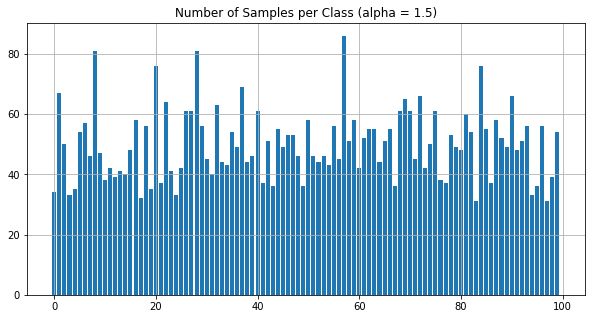

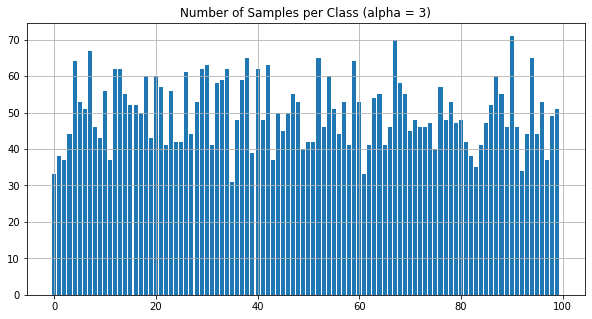

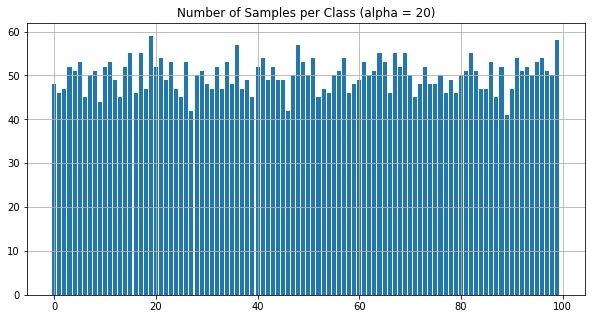

In [8]:
# plot_bar(dir_dist(y_train, 0.5), 0.5)
plot_bar(dir_dist(y_train, 1.5), 1.5)
plot_bar(dir_dist(y_train, 3), 3)
plot_bar(dir_dist(y_train, 20), 20)

In [10]:
batch_idx = dir_dist(y_train, 1.5)
len(batch_idx), len(batch_idx[0]), len(batch_idx[1]), len(batch_idx[2])

(100, 42, 56, 38)

## Single User Experiment

In [11]:
# Find a user with mose data
max_len, max_idx = 0, None
for ii, dd in enumerate(batch_idx):
    max_idx, max_len = (ii, len(dd)) if max_len < len(dd) else (max_idx, max_len)
print(max_idx, max_len)

64 92


In [12]:
user_idx = 64
len(batch_idx[user_idx]), y_train[batch_idx[user_idx]].shape

(92, (92,))

In [13]:
xx_train = x_train[batch_idx[user_idx]]
yy_train = y_train[batch_idx[user_idx]]
type(xx_train), xx_train.dtype, xx_train.shape

(numpy.ndarray, dtype('uint8'), (92, 3072))

## Define Custom Dataset

In [14]:
class FEDCIFAR100Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])
        img = img.reshape(-1, 32, 32).transpose(1, 2, 0)
            
        if not isinstance(target, np.ndarray):
            target = np.array(target)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

### Transforms
The normalization is an important step.
To be consider the true mean and std values of the dataset we need to calculate it 
base on the entire dataset. For this test purpose we just use arbitrary mean and std for all three layers.

In [22]:
tranforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[n/255. for n in (129.30428, 124.07023, 112.43411)], 
        std=[n/255. for n in (68.17024, 65.391785, 70.4184)]
    )
])

In [23]:
user_train_ds = FEDCIFAR100Dataset(xx_train, yy_train, tranforms_)
user_test_ds = FEDCIFAR100Dataset(x_test, y_test, tranforms_)
trainLoader = DataLoader(user_train_ds, batch_size=15, drop_last=True)
testLoader = DataLoader(user_test_ds, batch_size=20, drop_last=False)

In [24]:
img, label =user_train_ds[25]
type(img), img.shape, img.mean(), img.max(), img.min()

(torch.Tensor,
 torch.Size([3, 32, 32]),
 tensor(-0.6198),
 tensor(1.2718),
 tensor(-1.7138))

### Visualization (without normalization)

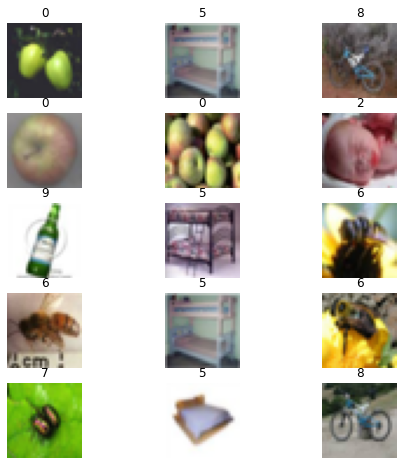

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(user_train_ds), size=(1,)).item()
    img, label = user_train_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

## Train and Test functions

In [25]:
def train_model(trainLoader, model, epochs):
    log_interval = 99
    train_loss = []
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # enumerate epochs
    for epoch in trange(epochs):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(trainLoader):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            outputs = model(inputs)
            # calculate loss
            loss = criterion(outputs, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        train_loss.append(loss.item())
        # evaluate_model(testLoader, model, criterion)
        if epoch == log_interval:
            print(f'Train Epoch: {epoch:<2} \tLoss: {loss.item():.6f}')
    
    return train_loss
        

In [26]:
# evaluate the model
def evaluate_model(testLoader, model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}')
    return 100 * correct / total

## Defining the Model

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_ = Net()

## Train and Test 

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loss = []
test_acc = []
rounds = 20
epoch = 10
for ii in range(rounds):
    train_loss.extend(train_model(trainLoader, model_, epoch))
    test_acc.append(evaluate_model(testLoader, model_))

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.04


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.14


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.39


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.58


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.74


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 1.98


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.16


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.34


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.39


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.39


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.43


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.44


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.48


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.49


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.48


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.52


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.51


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 2.5


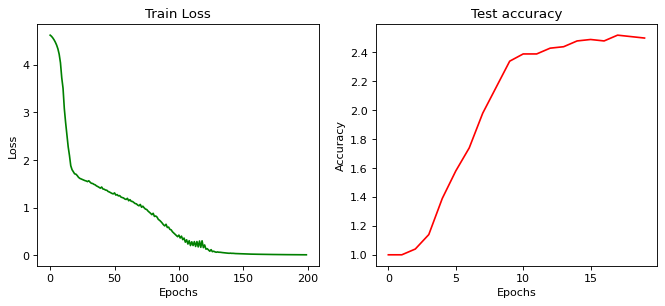

In [34]:
plt.figure(figsize=(10, 4), dpi=80)
rounds_ = range(rounds)
epochs_rounds = range(epoch*rounds)
plt.subplot(1, 2, 1)
plt.plot(epochs_rounds, train_loss, 'g')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(rounds_, test_acc, 'r')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()